### Import Libraries

In [143]:
import pandas as pd 
from pandas.api.types import CategoricalDtype

import numpy as np 
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Import Data , light cleaning

In [144]:
house_data = pd.read_csv('data/kc_house_data.csv')

test_data = house_data[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
                        'condition','grade', 'yr_built', 'zipcode', 'view', 'price'
                       ]].copy()

# Drop duplicates 
test_data.drop_duplicates(subset= 'id', keep='first', inplace=True, ignore_index = True)

# bedrooms drop all greater than 6
test_data.drop(test_data.index[test_data['bedrooms'] >= 7], inplace = True) # ---- UNDO

#bathrooms remove all nulls
test_data['bathrooms'] = test_data['bathrooms'].dropna()

# Price drop outliers 
test_data['price'] = test_data['price'].map(lambda x: np.log(x)) 

# Waterfront drop nulls 
house_data = house_data[house_data['waterfront'].notna()]

# View dropna
test_data = test_data[test_data['view'].notna()]

# grade drop single low value
test_data = test_data[test_data['grade'] != '3 Poor']
# **************************************************************************************
# ABOVE IS GOOD 

## Value Mapping Ordinal Variables

In [145]:
# Map values 0-1 to ordinal categorical
test_data.condition.replace({'Poor':0.2, 'Fair': 0.4, 'Average':0.6, 'Good':0.8, 'Very Good': 1.0}, inplace = True)

test_data.grade.replace({'4 Low': 0.1, '5 Fair':0.2, '6 Low Average':0.3, '7 Average':0.4,'8 Good':0.5,
                 '9 Better':0.6, '10 Very Good':0.7, '11 Excellent':0.8,'12 Luxury':0.9, 
                 '13 Mansion':1.0}, inplace = True)

## Ordinal Encoding Ordinal Variable

In [146]:
ord_cat_selector = ['view'] # ----for testin
cat_subset = test_data[ord_cat_selector]
ordered_view = ['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT']
o_enc = OrdinalEncoder(categories = [ordered_view]) # --- original
o_enc.fit(cat_subset)
X_subset = pd.DataFrame(o_enc.transform(cat_subset),
                       columns = cat_subset.columns)

## Optimal Price Prediction

In [161]:
# Predict price
nom_features = ['bathrooms','price', 'sqft_living', 'grade', 'bedrooms'] # ---TEST
# bedrooms, yearBuilt, grade, sqft, price,


dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)

X_p = pd.concat([test_data[nom_features], dum_year, dum_zipcode],join = 'inner', axis = 1) 


X = X_p.drop(columns = 'price')
y = X_p['price']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3)

In [162]:
# Fit price print values R Score =  0.831
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p = lr_p.predict(X_test_p)
R_p = lr_p.score(X_train_p, y_train_p)
MAE_p = mean_absolute_error(np.exp(y_pred_p), np.exp(y_test_p))
RMSE_p = np.sqrt(mean_squared_error(np.exp(y_pred_p), np.exp(y_test_p)))
print('Price Prediction:' '\n' 'R Score = ', R_p, '\n' 'MAE = ', MAE_p,
      '\n' 'RMSE = ', RMSE_p, '\n' 'First five predicted values : ', y_pred_p[0:5])

Price Prediction:
R Score =  0.8519989742809111 
MAE =  80502.69152334603 
RMSE =  154172.97557671616 
First five predicted values :  [13.19717845 12.66573134 13.09473643 13.20185262 13.75651636]


## Comparing Predicted and Real price values

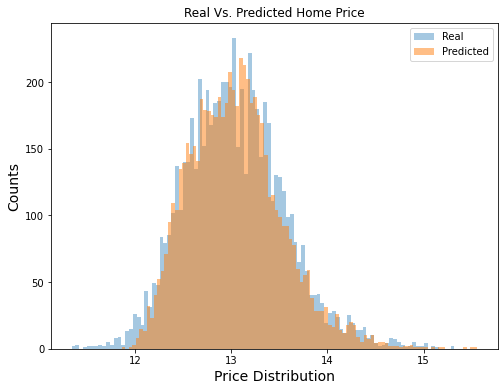

In [164]:
plt.figure(figsize=(8,6))
plt.hist(y_test_p, bins=100, alpha=0.4, label="Real")
plt.hist(y_pred_p, bins=100, alpha=0.5, label="Predicted")
plt.xlabel("Price Distribution", size=14)
plt.ylabel("Counts", size=14)
plt.title("Real Vs. Predicted Home Price")
plt.legend(loc='upper right');

### Side -- predicting grade using predicted price 

In [165]:
# Predict grade
nom_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                 'price', 'grade'] #test--- R Score =  0.757

dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)
X_ = pd.concat([test_data[nom_features], X_subset, dum_year, dum_zipcode],join = 'inner', axis = 1) #-- original

X = X_.drop(columns = 'grade')
y = X_['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [166]:
# Fit grade print Values R Score =  0.749
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
R = lr.score(X_train, y_train)
MAE = mean_absolute_error(y_pred, y_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
COEF = lr.coef_
print('Grade Prediction:' '\n' 'R Score = ', R, '\n' 'MAE = ', MAE, '\n' 'RMSE = ', RMSE, '\n' 
      'First five predicted values : ', y_pred[0:5])

Grade Prediction:
R Score =  0.7471639216137816 
MAE =  0.045679303675182116 
RMSE =  0.05871520627909765 
First five predicted values :  [0.30115692 0.49542064 0.55678628 0.56814563 0.39243262]


# Exploring Correlations to Solve First-time Homebuyer Problem

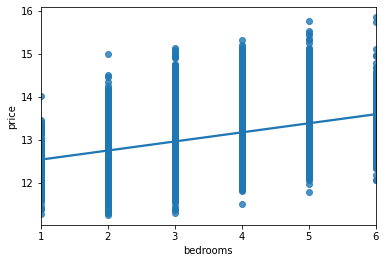

In [151]:
sns.regplot(test_data.bedrooms,test_data.price, fit_reg = True);

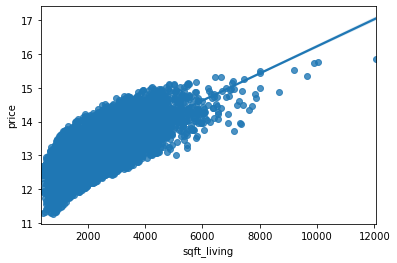

In [152]:
sns.regplot(test_data.sqft_living,test_data.price, fit_reg = True);

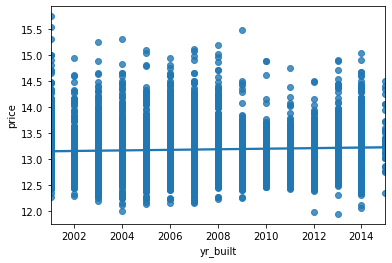

In [153]:
sns.regplot(test_data['yr_built'].loc[test_data.yr_built > 2000],
            test_data['price'].loc[test_data.yr_built > 2000], fit_reg = True);

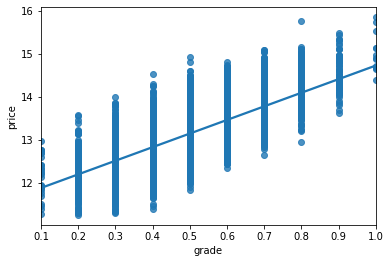

In [154]:
sns.regplot(test_data.grade, test_data.price, fit_reg = True);

## Combining Relevant Home Buyer Criteria and optimal prediction criteria 

In [170]:
bedrooms = pd.Series(test_data.bedrooms , name = 'bedrooms')
yearBuilt = pd.Series(test_data['yr_built'].loc[test_data.yr_built > 2000] , name = 'year_built')
grade = pd.Series(test_data['grade'].loc[test_data.grade >= 0.5], name = 'grade')
sqft = pd.Series(test_data['sqft_living'].loc[test_data.sqft_living > 2000] , name = 'sqft')
price = pd.Series(test_data['price'], name = 'price')

# combi_df = pd.concat([bedrooms, yearBuilt, grade, sqft, price],join = 'inner', axis = 1) 
combi_df = pd.concat([bedrooms, yearBuilt, grade, sqft, price, dum_year, dum_zipcode],join = 'inner', axis = 1) 


X = combi_df.drop(columns = 'price')
y = combi_df['price']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3)

In [171]:
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p = lr_p.predict(X_test_p)
R_p = lr_p.score(X_train_p, y_train_p)
MAE_p = mean_absolute_error(np.exp(y_pred_p), np.exp(y_test_p))
RMSE_p = np.sqrt(mean_squared_error(np.exp(y_pred_p), np.exp(y_test_p)))
print('Price Prediction:' '\n' 'R Score = ', R_p, '\n' 'MAE = ', MAE_p,
      '\n' 'RMSE = ', RMSE_p, '\n' 'First five predicted values : ', y_pred_p[0:5])

Price Prediction:
R Score =  0.8919406480368488 
MAE =  109929.59087626197 
RMSE =  220494.25123847096 
First five predicted values :  [13.00697947 13.06479311 14.24085402 13.45347023 15.0583005 ]


## Plotting Predicted vs Actual using Home Buyer Criteria

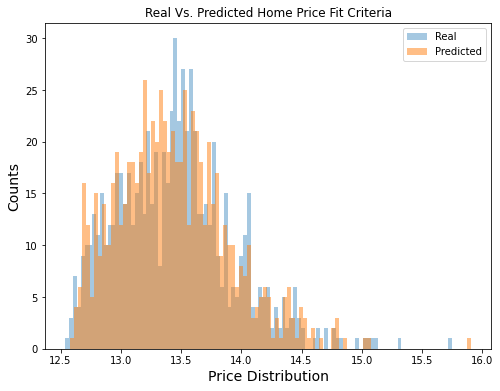

In [172]:
plt.figure(figsize=(8,6))
plt.hist(y_test_p, bins=100, alpha=0.4, label="Real")
plt.hist(y_pred_p, bins=100, alpha=0.5, label="Predicted")
plt.xlabel("Price Distribution", size=14)
plt.ylabel("Counts", size=14)
plt.title("Real Vs. Predicted Home Price Fit Criteria")
plt.legend(loc='upper right');

## Mean Predicted Home Price Given Criteria

In [173]:
Mean_Predicted_price = np.exp(y_pred_p.mean())
print('Mean Predicted Home Price: ', Mean_Predicted_price)

Mean Predicted Home Price:  685682.5538182135
